In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import joblib

In [18]:
# Set random seed for reproducibility
np.random.seed(42)

In [19]:
# Load the dataset
df = pd.read_csv('data/df_.csv')

In [20]:
# 1. DATA EXPLORATION
print("Dataset Shape:", df.shape)

print("\nData Types:")
print(df.dtypes)

print("\nMissing Values:")
print(df.isnull().sum())

#df = df.dropna(axis=0)
print("Dataset Shape:", df.shape)

Dataset Shape: (178, 17)

Data Types:
school_code                 object
prev_sat                   float64
SCHOOL OWNERSHIP            object
SCHOOL CATEGORY             object
SCHOOL TYPE                 object
COMBINATIONS CATEGORY       object
ACADEMIC LEVEL CATEGORY     object
prev_gpa                   float64
gpa                        float64
sat                        float64
STUDENTS                   float64
TEACHERS                   float64
STUDENT-TEACHER RATIO       object
student_teacher_ratio      float64
studying_hours             float64
number_of_books              int64
teacher_qualification       object
dtype: object

Missing Values:
school_code                 0
prev_sat                    0
SCHOOL OWNERSHIP            0
SCHOOL CATEGORY             0
SCHOOL TYPE                 5
COMBINATIONS CATEGORY      11
ACADEMIC LEVEL CATEGORY    11
prev_gpa                    1
gpa                         0
sat                         0
STUDENTS                    0
TEACHE

In [21]:
# Basic statistics for numeric columns
print("\nNumeric Data Summary:")
df.describe()


Numeric Data Summary:


,prev_sat,prev_gpa,gpa,sat,STUDENTS,TEACHERS,student_teacher_ratio,studying_hours,number_of_books
count,178.000000,177.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,113.084270,2.560664,2.456174,117.404494,661.123596,40.022472,16.451816,99.314844,538.702247
std,126.447232,0.497044,0.470863,129.341725,433.651252,19.455572,5.631726,27.599192,132.094283
min,1.000000,1.289100,1.365700,2.000000,144.000000,10.000000,8.947368,7.804424,40.000000
25%,29.250000,2.244400,2.136675,31.000000,400.000000,30.000000,12.500000,79.837082,460.250000
50%,63.000000,2.618800,2.404600,73.500000,545.000000,35.000000,15.058140,99.351690,532.500000
75%,142.250000,2.853700,2.760550,147.750000,800.000000,50.000000,19.933333,117.747282,616.750000
max,676.000000,3.654600,3.738100,585.000000,3500.000000,115.000000,41.860465,166.325219,877.000000


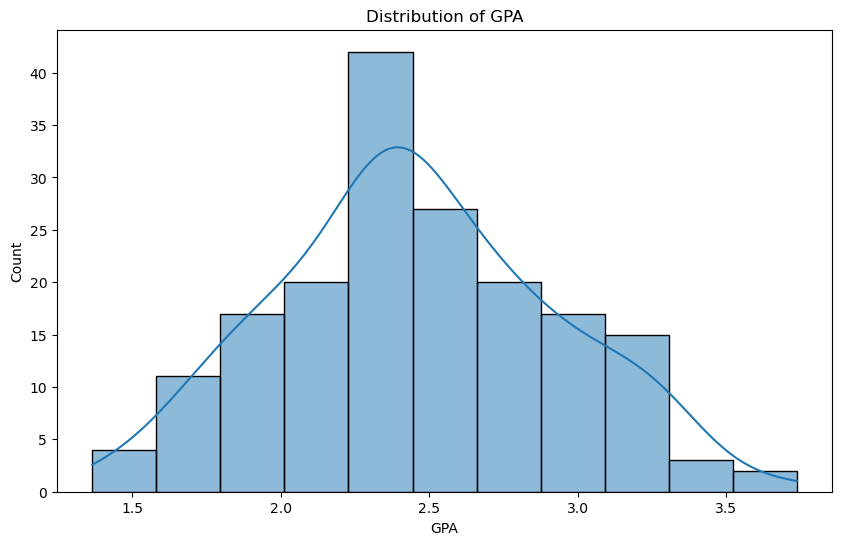

In [22]:
# Check distribution of the target variable (GPA)
plt.figure(figsize=(10, 6))
sns.histplot(df['gpa'], kde=True)
plt.title('Distribution of GPA')
plt.xlabel('GPA')
plt.show() #vplt.savefig('gpa_distribution.png')
plt.close()

In [23]:
# Analysis of categorical variables in relation to GPA
categorical_cols = ['SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE', 
                    'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY','teacher_qualification']

In [24]:
# Create a function to plot the relationship between categorical features and GPA
def plot_categorical_vs_gpa(df, col):
    if df[col].notnull().sum() > 0:  # Only plot if there are non-null values
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=col, y='gpa', data=df)
        plt.title(f'GPA by {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show() # plt.savefig(f'gpa_by_{col.lower().replace(" ", "_")}.png')
        plt.close()

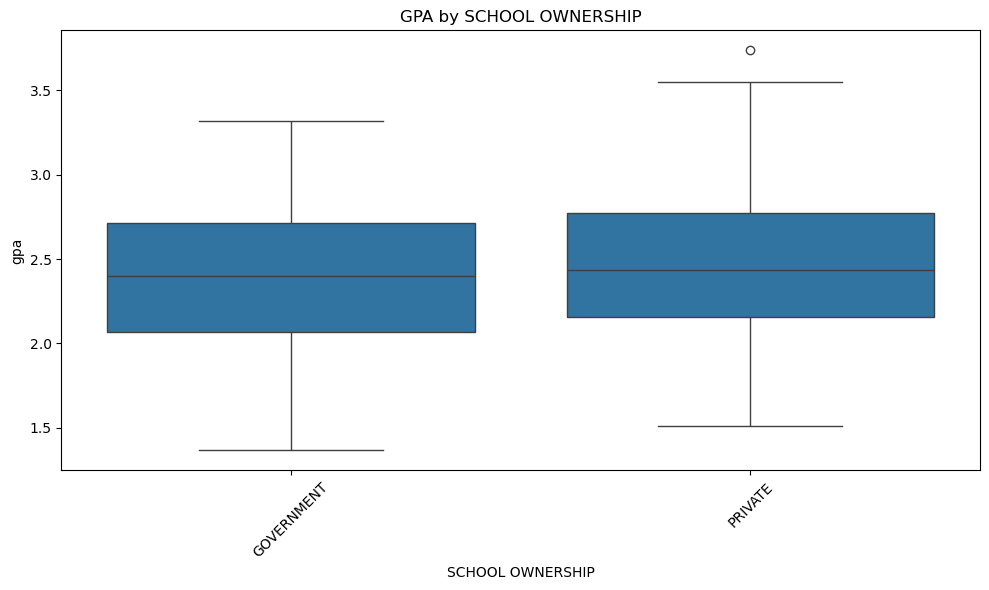

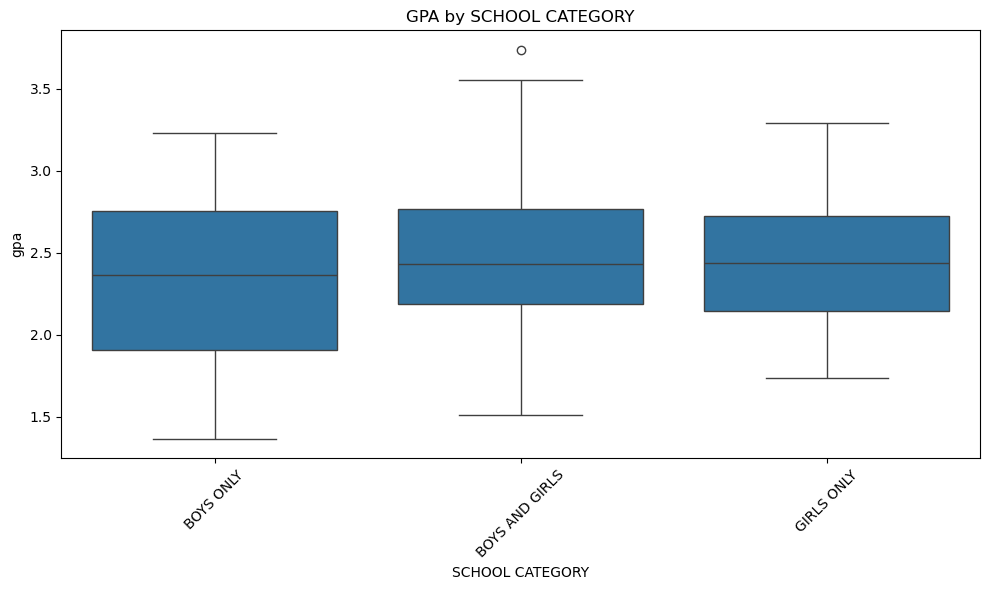

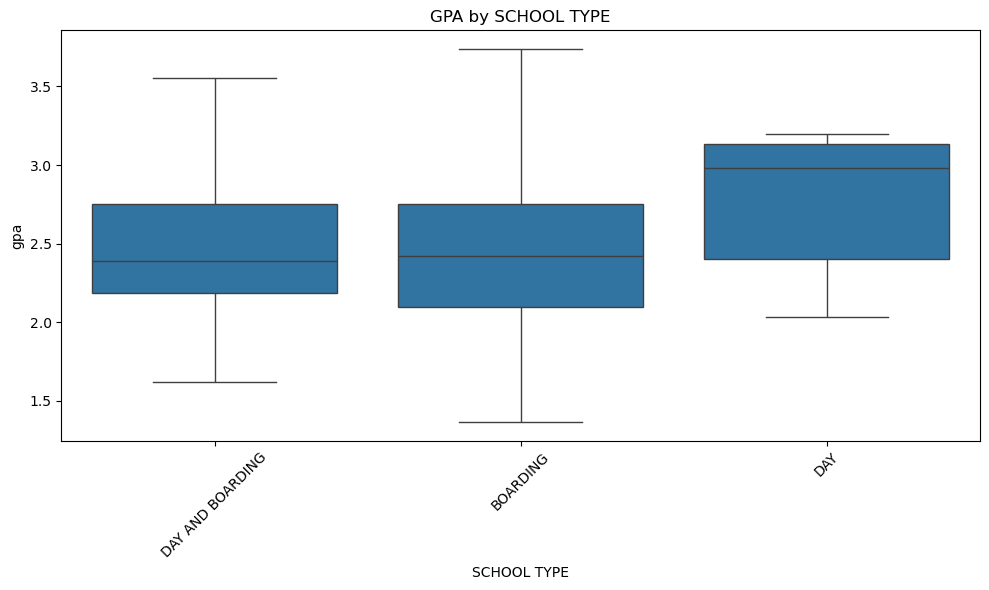

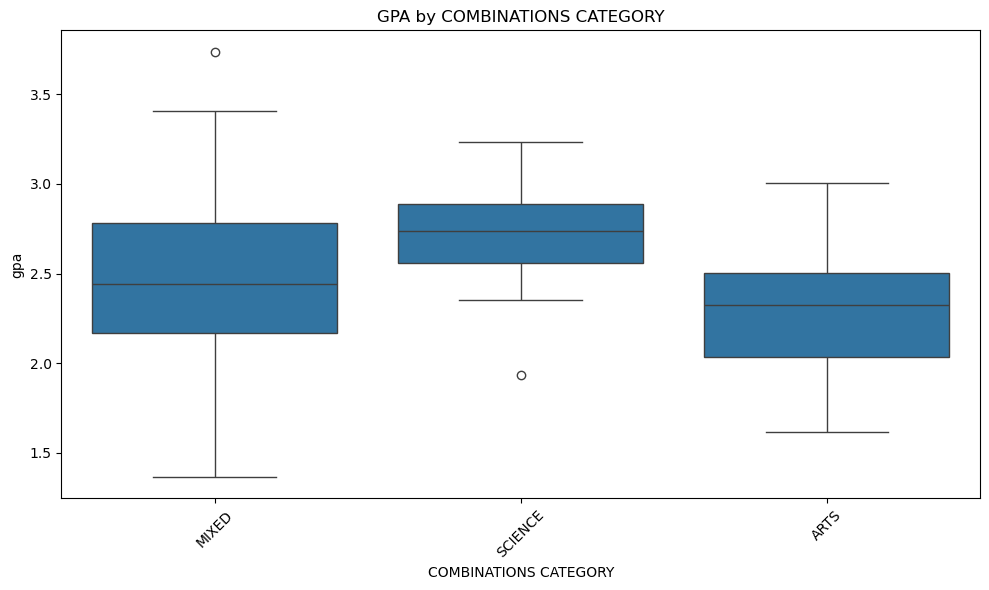

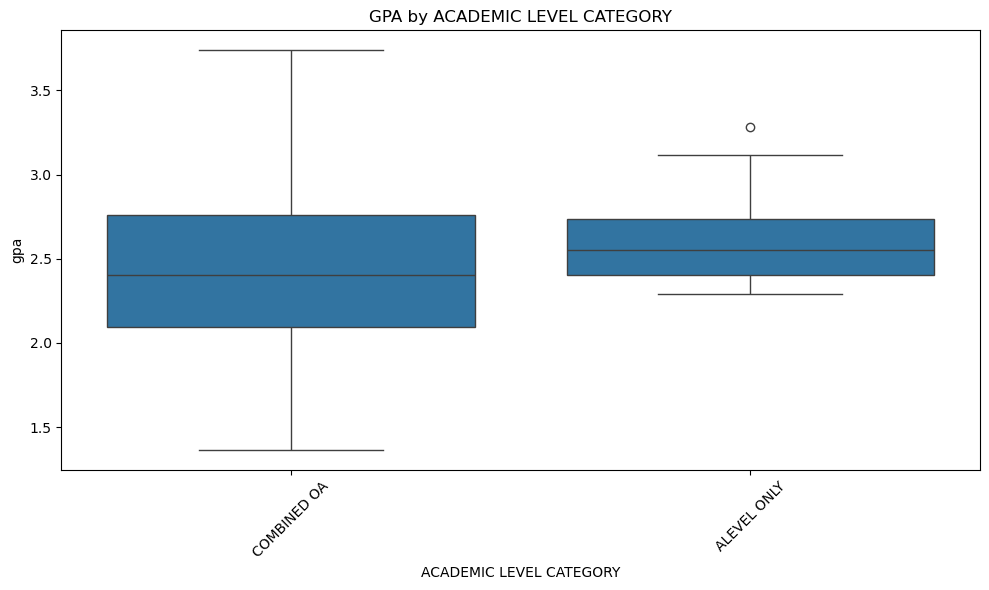

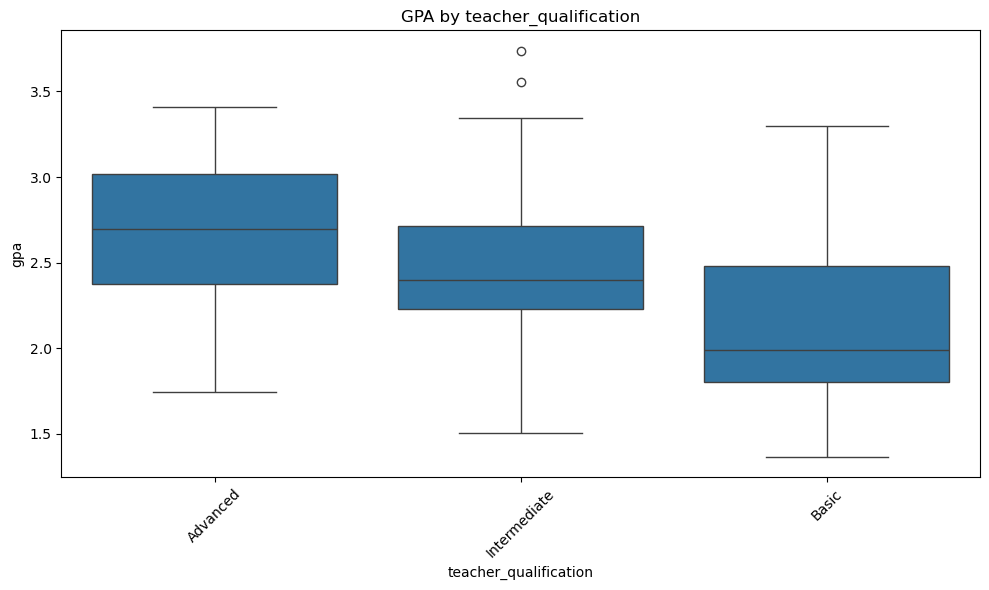

In [25]:
# Plot for each categorical column
for col in categorical_cols:
    plot_categorical_vs_gpa(df, col)

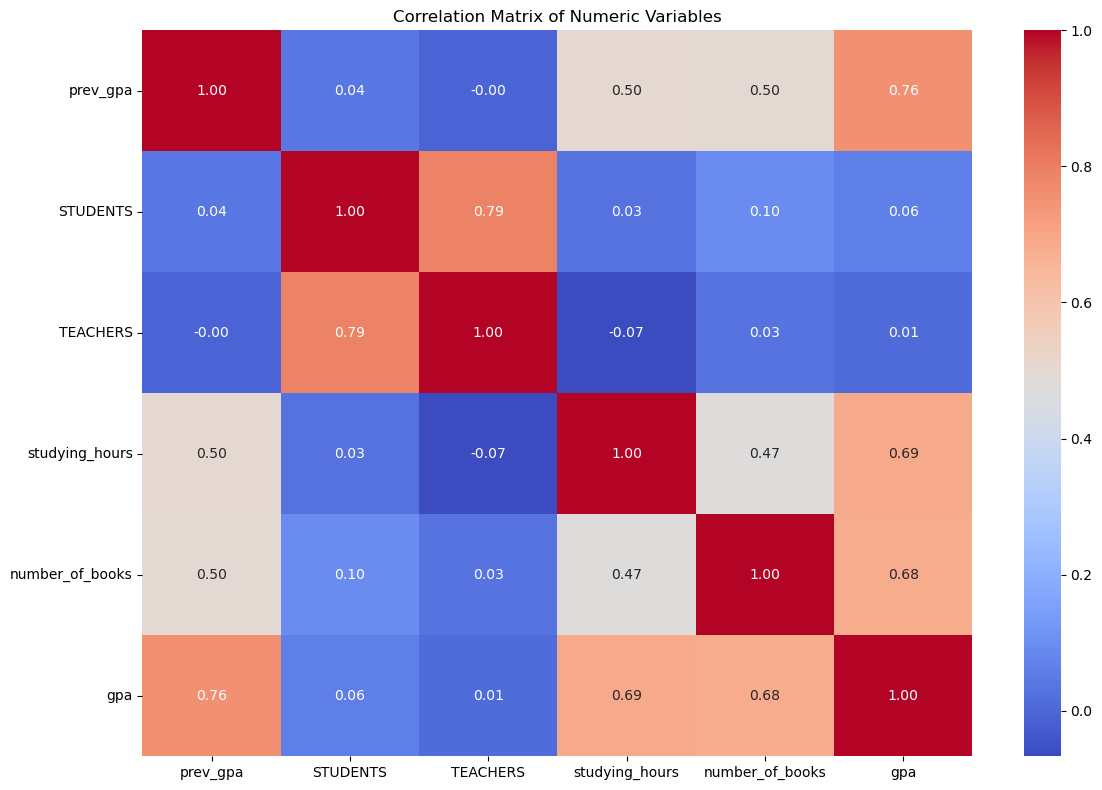

In [26]:
# Correlation matrix for numeric columns
# numeric_cols = ['student_teacher_ratio','prev_sat', 'prev_gpa', 'gpa', 'sat']
numeric_cols = ['prev_gpa', 'STUDENTS', 'TEACHERS', 'STUDENT-TEACHER RATIO', 'studying_hours', 'number_of_books','gpa']
plt.figure(figsize=(12, 8))
correlation = df[numeric_cols].corr(numeric_only=True)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Variables')
plt.tight_layout()
plt.show() # plt.savefig('correlation_matrix.png')
plt.close()

In [27]:
print("\nCorrelation with GPA:")
print(correlation['gpa'].sort_values(ascending=False))


Correlation with GPA:
gpa                1.000000
prev_gpa           0.755639
studying_hours     0.687897
number_of_books    0.682854
STUDENTS           0.061555
TEACHERS           0.010186
Name: gpa, dtype: float64


In [28]:
# 2. FEATURE ENGINEERING

# Create interaction terms
df['prev_gpa_sat_interaction'] = df['prev_gpa'] * df['prev_sat']

# Calculate SAT retention rate
df['sat_retention'] = df['sat'] / df['prev_sat']

In [29]:
# 3. FEATURE SELECTION AND PREPROCESSING
# Separate features and target
X = df.drop(['gpa','STUDENTS','TEACHERS'], axis=1)
y = df['gpa']

X_linear = df.dropna(axis=0).drop(['gpa','STUDENTS','TEACHERS'], axis=1)
y_linear = df.dropna(axis=0)['gpa']

numeric_cols = ['prev_sat', 'prev_gpa', 'prev_gpa_sat_interaction', 'student_teacher_ratio',
                'studying_hours', 'number_of_books', 'sat_retention']
# Define feature groups
# numeric_features = ['prev_sat', 'prev_gpa', 'sat', 'student_teacher_ratio',
#                      'prev_gpa_sat_interaction', 'sat_retention']
numeric_features = numeric_cols
categorical_features = ['SCHOOL OWNERSHIP', 'SCHOOL CATEGORY', 'SCHOOL TYPE',
                        'COMBINATIONS CATEGORY', 'ACADEMIC LEVEL CATEGORY', 'teacher_qualification']

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to apply the appropriate preprocessing to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [30]:
# 4. MODEL TRAINING AND EVALUATION
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models to try
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [31]:
# Function to evaluate models
def evaluate_model(model_name, model, X_train, X_test, y_train, y_test):
    # Create full pipeline with preprocessing
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    if model_name == 'Linear Regression':
        X_train, X_test, y_train, y_test = train_test_split(X_linear, y_linear, test_size=0.2, random_state=42)
    # Train the model
    full_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = full_pipeline.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(full_pipeline, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Print results
    print(f"\nModel: {model_name}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")
    print(f"Cross-validation RMSE: {cv_rmse:.4f}")

    # Save the model
    os.makedirs('models/new', exist_ok=True)
    model_path = os.path.join('models/new', f'{model_name.replace(" ", "_").lower()}_pipeline.pkl')
    joblib.dump(full_pipeline, model_path)
    print(f"Model saved to: {model_path}")
    
    return {
        'model_name': model_name,
        'pipeline': full_pipeline,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'cv_rmse': cv_rmse
    }

In [32]:
# Evaluate all models
results = []
for name, model in models.items():
    result = evaluate_model(name, model, X_train, X_test, y_train, y_test)
    results.append(result)


Model: Linear Regression
Test RMSE: 0.1935
Test MAE: 0.1462
Test R²: 0.8386
Cross-validation RMSE: 0.2333
Model saved to: models/new/linear_regression_pipeline.pkl

Model: Random Forest
Test RMSE: 0.2529
Test MAE: 0.2002
Test R²: 0.6333
Cross-validation RMSE: 0.2411
Model saved to: models/new/random_forest_pipeline.pkl

Model: Gradient Boosting
Test RMSE: 0.2698
Test MAE: 0.2180
Test R²: 0.5827
Cross-validation RMSE: 0.2437
Model saved to: models/new/gradient_boosting_pipeline.pkl


In [33]:
# Find the best model based on RMSE
best_model = min(results, key=lambda x: x['rmse'])
print(f"\nBest model: {best_model['model_name']} with RMSE: {best_model['rmse']:.4f}")

# 5. FEATURE IMPORTANCE ANALYSIS (for the best model)
if best_model['model_name'] in ['Random Forest', 'Gradient Boosting']:
    # Get feature names after preprocessing
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_features) + list(cat_features)
    
    # Extract the model from the pipeline
    model_instance = best_model['pipeline'].named_steps['model']
    
    # Get feature importances
    feature_importances = model_instance.feature_importances_
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)[::-1]
    
    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance ({best_model["model_name"]})')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.close()
    
    print("\nTop 10 Most Important Features:")
    for i in range(min(10, len(sorted_idx))):
        print(f"{feature_names[sorted_idx[i]]}: {feature_importances[sorted_idx[i]]:.4f}")


Best model: Linear Regression with RMSE: 0.1935


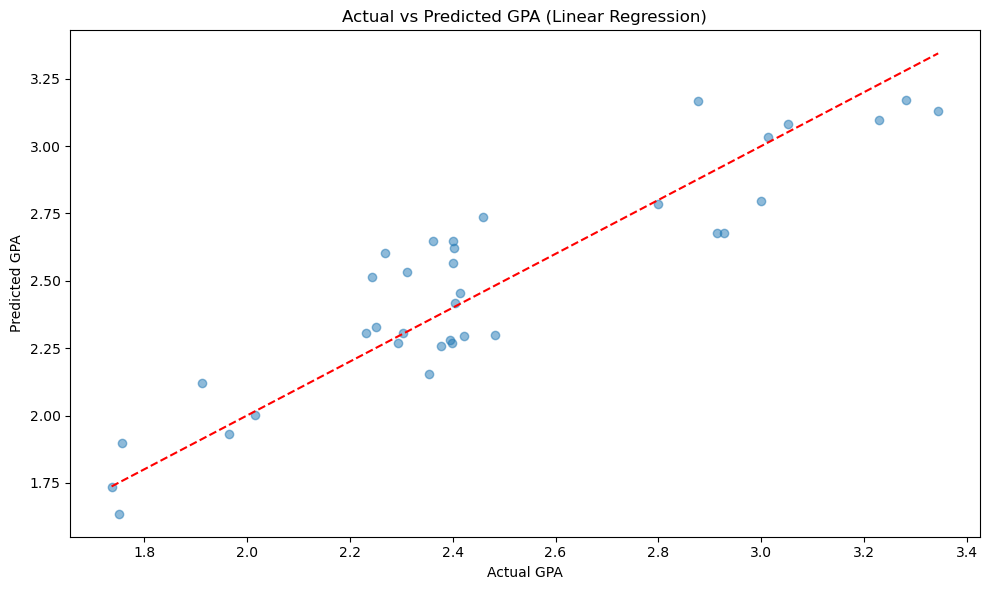

In [34]:
# 6. MODEL INTERPRETATION
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
y_pred = best_model['pipeline'].predict(X_test)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual GPA')
plt.ylabel('Predicted GPA')
plt.title(f'Actual vs Predicted GPA ({best_model["model_name"]})')
plt.tight_layout()
plt.show() # plt.savefig('actual_vs_predicted.png')
plt.close()

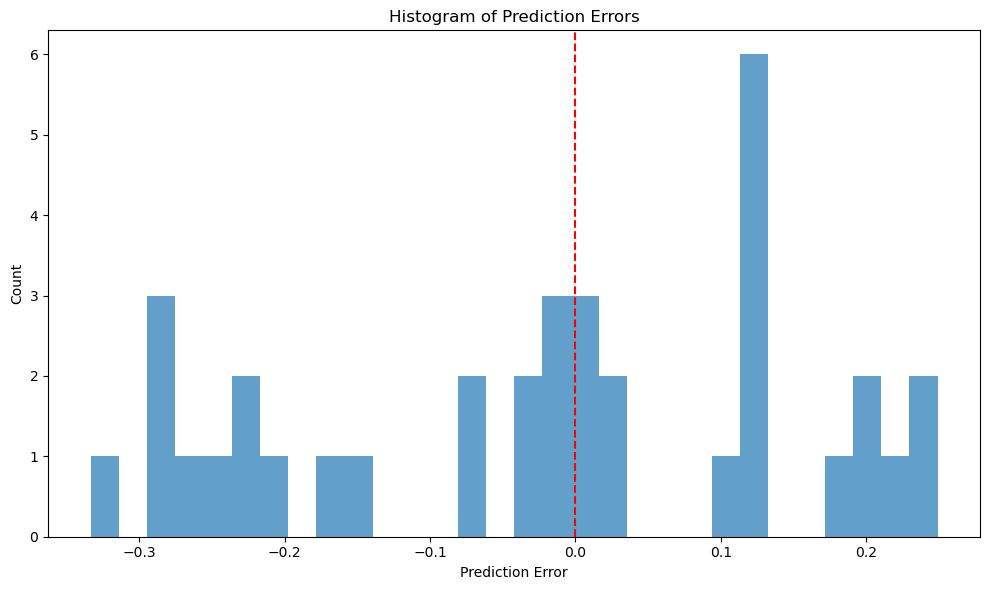

In [35]:
# Plot prediction errors
plt.figure(figsize=(10, 6))
errors = y_test - y_pred
plt.hist(errors, bins=30, alpha=0.7)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Histogram of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show() # plt.savefig('prediction_errors.png')
plt.close()